# HW03: due October th 

The goal of this homework is to **predict** the value of houses in California starting from house and neighborhood caracteristics. 

Differently from last week's homework, we are not interested in investigating the causal effect of some features on house values, but the main purpose is to obtain good predictions of the values, so to train the best model to minimize the loss function. 

In [1]:
# Load Data
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
print(data['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [2]:
X_full, y_full = data.data, data.target
n_samples = X_full.shape[0]
n_features = X_full.shape[1]
print(n_samples,n_features)

20640 8


# Summary Statistics

In [3]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

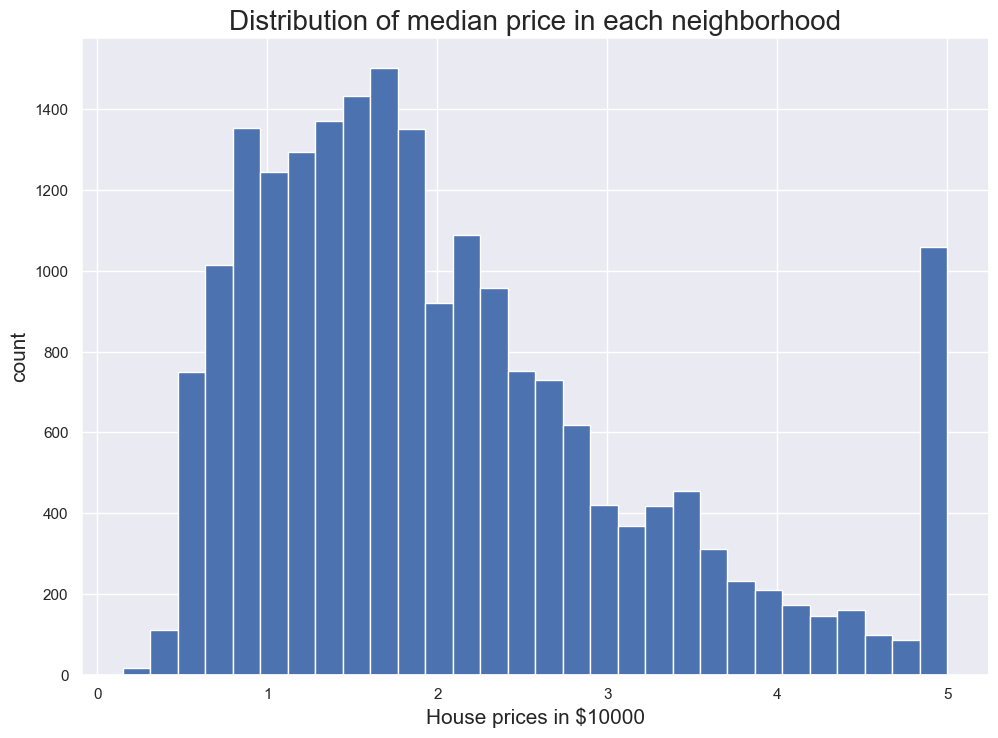

In [4]:
from seaborn import distplot
# make a histogram of the label variable
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.hist(y_full, bins=30)
plt.xlabel("House prices in $10000", size=15)
plt.ylabel('count', size=15)
plt.title('Distribution of median price in each neighborhood', size=20)
plt.show()
#TODO

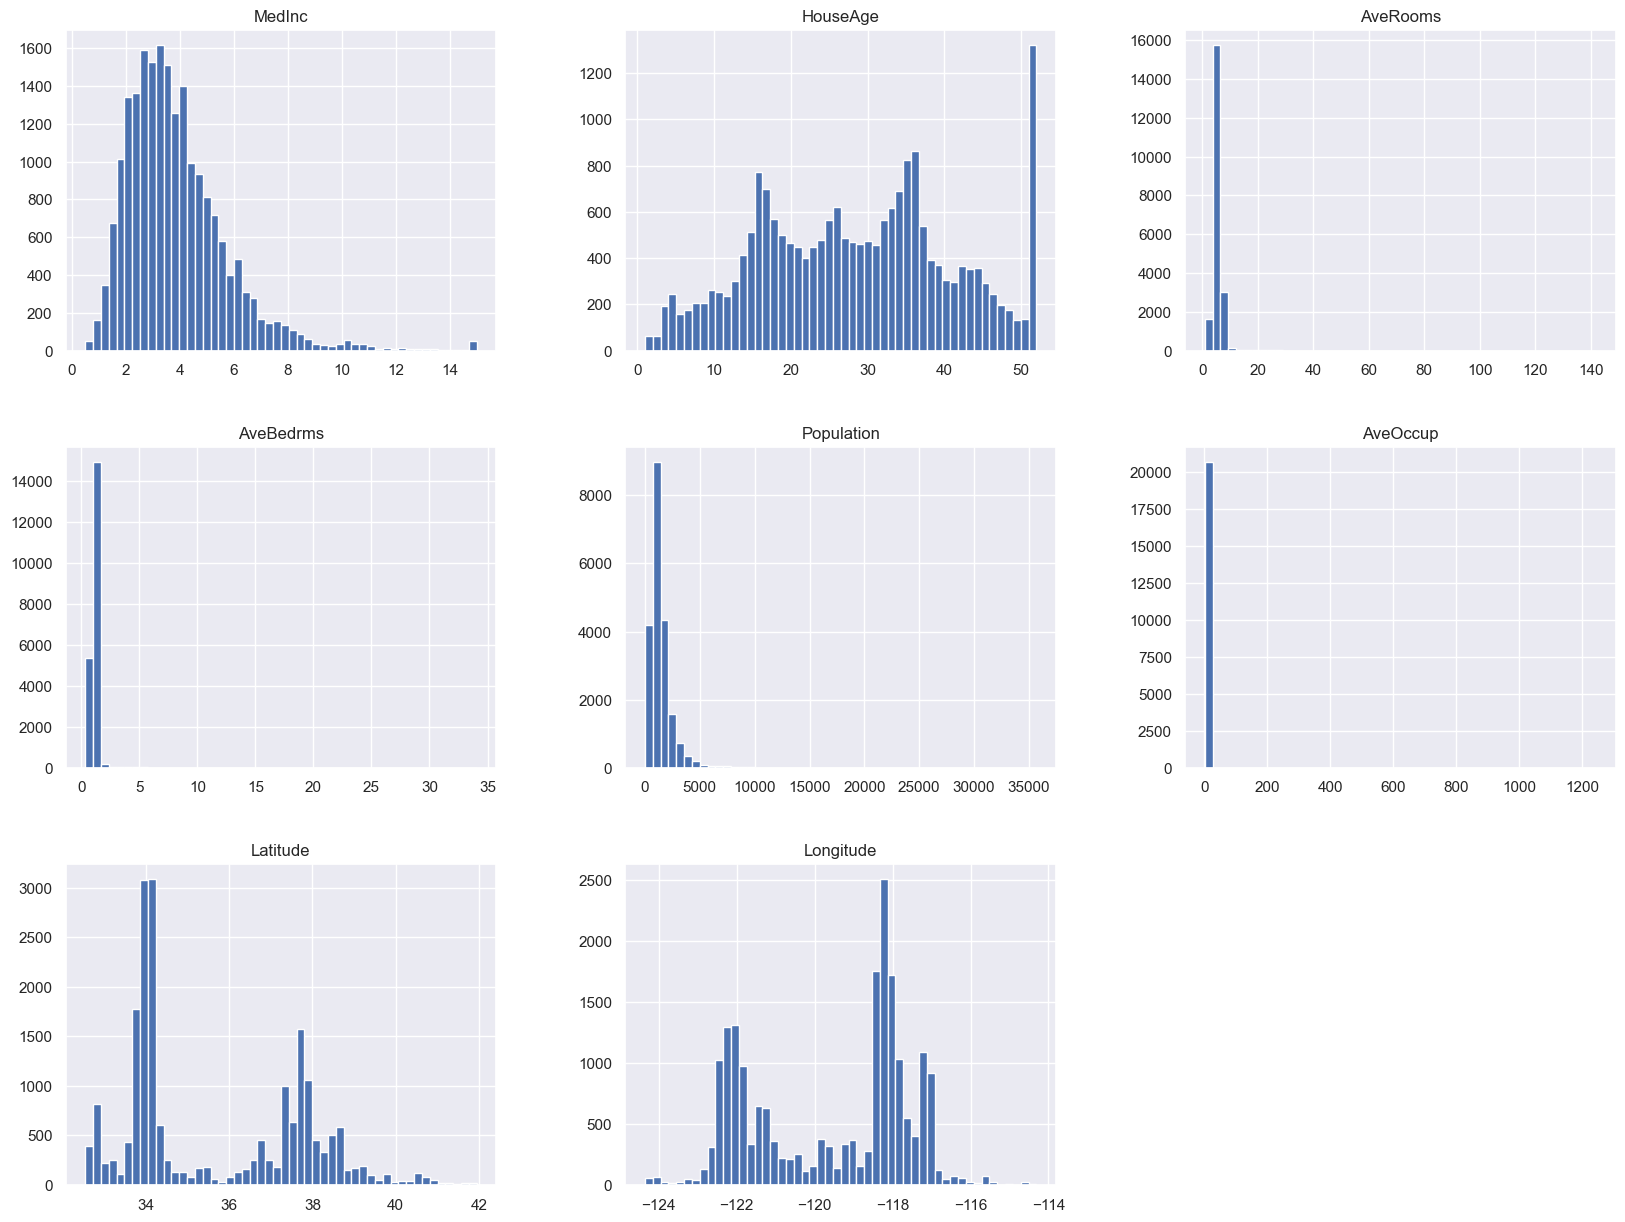

In [5]:
# make histograms of all predictors
X_df=pd.DataFrame(X_full, columns=data['feature_names'])
X_df.hist(bins=50, figsize=(20,15))
plt.show()
#TODO

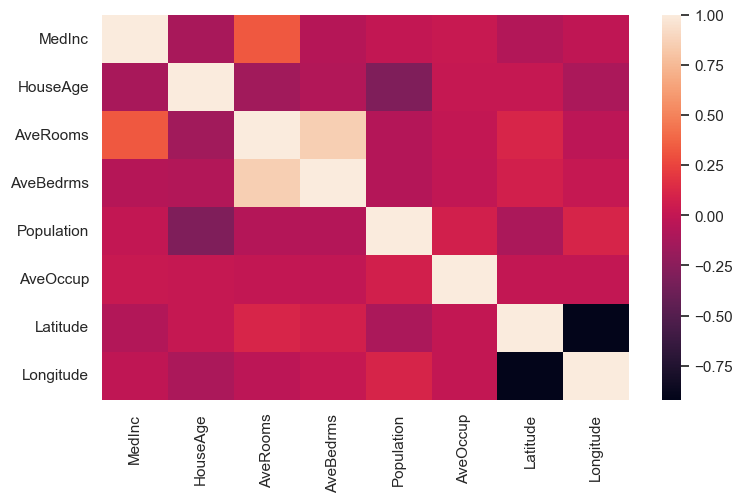

In [6]:
# Check for correlations
sns.set(rc={'figure.figsize':(8.5,5)})
correlation_matrix = X_df.corr().round(2)
sns.heatmap(correlation_matrix) #annot=True
plt.show()

Based on the figure above, we can see a strong correlation between Longitude and Latitude, as well as AveRooms and AveBedrms. This can affect the model.

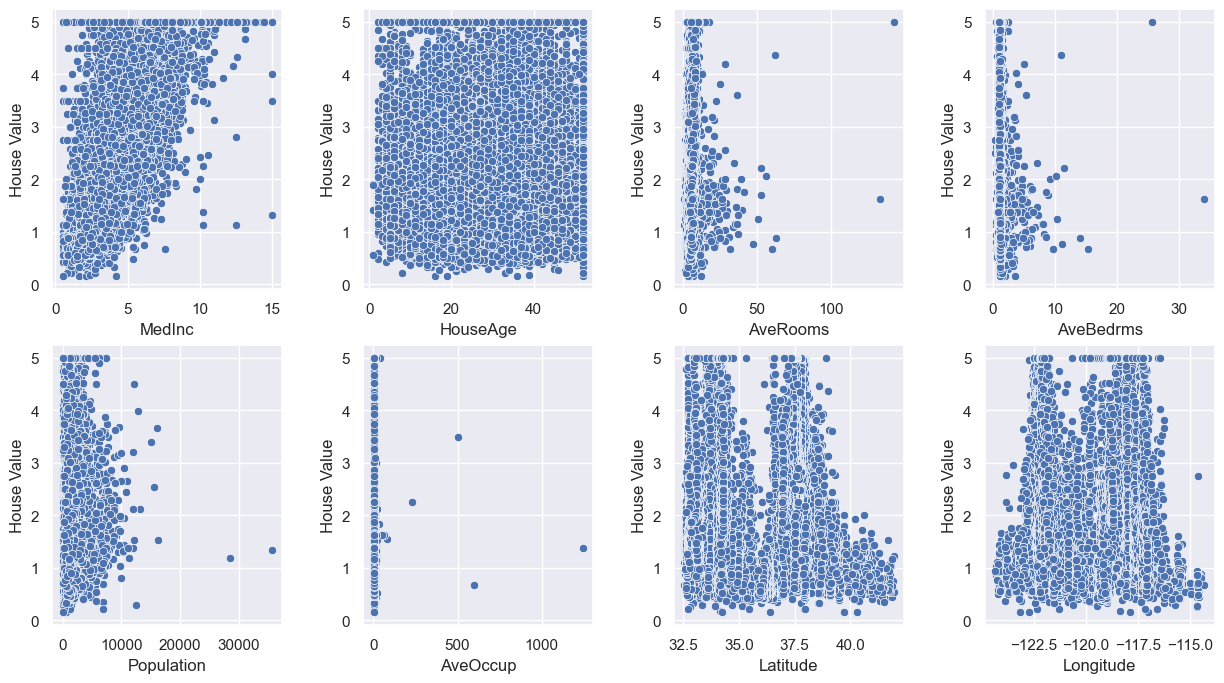

In [7]:
from seaborn import scatterplot
# make scatterplots of all predictors with the label
fig, ax= plt.subplots(2, 4)
fig.set_size_inches(15, 8)
fig.subplots_adjust(wspace=0.35)

for i, ax_i in zip(range(0, len(X_full.T)), ax.reshape(-1)):
    xplt = scatterplot(x=X_full.T[i], y=y_full, ax=ax_i)
    xplt.set(xlabel=data.feature_names[i], ylabel='House Value')


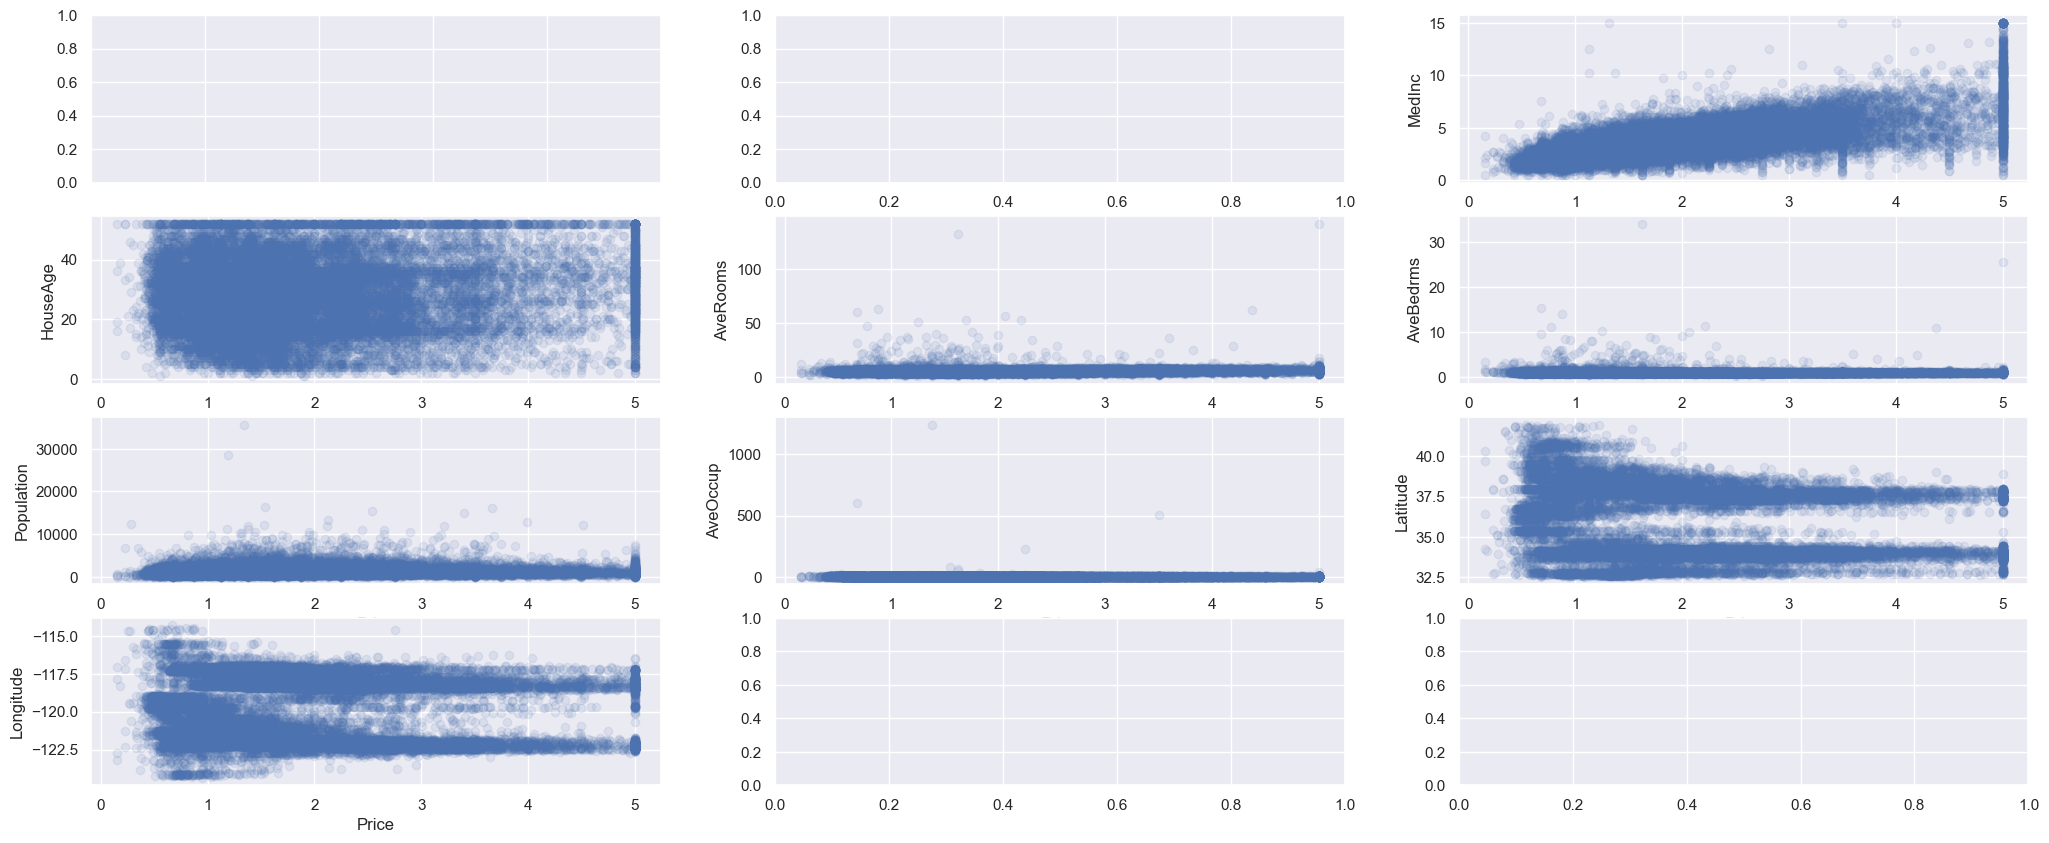

In [8]:
fig, ax = plt.subplots(4, 3, figsize=(25,10))
axe = ax.ravel()
axe[0].set_xticklabels([])
axe[0].set_xlabel(' ')
for i, feature_name in zip(range(1,11), X_df.columns):
    axe[i+1].scatter(y_full, X_df[feature_name], alpha=0.1)
    axe[i+1].set_xlabel('Price')
    axe[i+1].set_ylabel(feature_name)

Based on the figure above, we can identify a strong correlation between the variables. Therefore, moving forward, we will not consider AveBedrms and Latitude. We also observe that the house prices are capped at $50,000; therefore, any data above that needs to be removed.

In [9]:
# Remove data above $50,000
mask=y_full<=5

features_keep =['MedInc', 'HouseAge', 'AveRooms', 'Population', 'AveOccup', 'Latitude']
X_select = X_df[features_keep].to_numpy()

y_full=y_full[mask==True]
X_select=X_select[mask==True]

# Train/Test Split

In [10]:
from sklearn.model_selection import train_test_split
# Split the data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X_select, y_full,test_size=0.2, random_state=1)


# Pre-Processing

In [11]:
from sklearn.preprocessing import StandardScaler
# produce standardized predictors with mean zero and variance one 
# fit the transformer in the training set and apply to the whole data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test)
#TODO

In [12]:
from sklearn.preprocessing import PolynomialFeatures
# produce quadratic polynomial features from all standardized predictors
# squared values and pairwise interactions 
# fit the transformer in the training set and apply to the whole data
poly_features=PolynomialFeatures(degree=2)
X_train_poly=poly_features.fit_transform(X_train)
X_test_poly=poly_features.fit_transform(X_test)
#TODO

## Fractional Ridge Regression
https://arxiv.org/abs/2005.03220

https://nrdg.github.io/fracridge/

In [13]:
from fracridge import FracRidgeRegressorCV
from sklearn.metrics import mean_squared_error, r2_score
from seaborn import regplot

In [14]:
# train fractional ridge on raw predictors
# report the chosen fraction penalty
# report MSE and r-squared in test set 
fridge = FracRidgeRegressorCV()
fridge.fit(X_train, y_train)
pen = fridge.best_frac_
print("Chosen fraction penalty: %s" % pen)

y_pred = fridge.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE: %s" % mse)
print("R2: %s" % r2)

#TODO

Chosen fraction penalty: 1.0
MSE: 0.5071103537370893
R2: 0.45744291234284096


In [15]:
# train fractional ridge on standardized predictors
# report the chosen fraction penalty
# report MSE and r-squared in test set 

fridge.fit(X_train_scaled, y_train)
pen = fridge.best_frac_
print("Chosen fraction penalty: %s" % pen)

y_pred = fridge.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE: %s" % mse)
print("R2: %s" % r2)

Chosen fraction penalty: 0.9
MSE: 4.194044483546126
R2: -3.487205878815667


In [16]:
# train fractional ridge on standardized predictors including quadratics and interactions
# report the chosen fraction penalty
# report MSE and r-squared in test set 

fridge.fit(X_train_poly, y_train)
pen = fridge.best_frac_
print("Chosen fraction penalty: %s" % pen)

y_pred = fridge.predict(X_test_poly)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE: %s" % mse)
print("R2: %s" % r2)

Chosen fraction penalty: 0.1
MSE: 0.45285719453297685
R2: 0.5154883374402828


<AxesSubplot: >

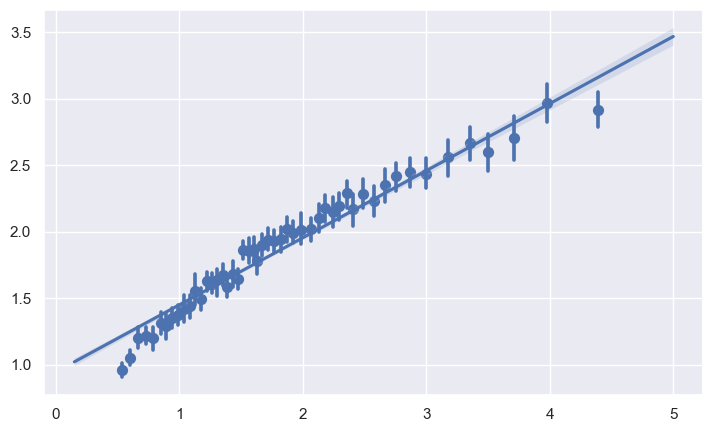

In [17]:
# report a binned regplot of the true outcome versus predictions in the test set
regplot(x=y_test, y=y_pred, x_bins=50)

**How do the results change when using different predictors? Which one do you think is the best model for this task? Explain.**

The best models are the one with the raw predictors, and the standardized model combined with quadratic and interaction terms, as they present the largest R-squared and the lowest mean squared error.